## Sensitivity Analysis

Some experimentation with local and global sensitivity analysis based on the notebook provided by the course and some articles

#### References
- Broeke, G. ten, Voorn, G. van, Ligtenberg, A. (2016). Which Sensitivity Analysis Method Should I Use for My Agent-Based Model?



### OFAT
One-Factor-At-a-Time: Method of local sensitivity analysis, where one input parameter is varied and the others are kept fixed. According to ten Broeke (2016) a pre-test needs to be done to ensure a the model converges to a steady state behaviour. This might prove problematic for our model, since we examine early stage colonies, and in the results from the ODE model, the ant and fungus biomass are still increasing vastly. 

In [1]:
from leafcutter_ants_fungi_mutualism.model import LeafcutterAntsFungiMutualismModel, track_ants
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
"""
Pre-test to determine whether the model converges to a steady state behaviour
"""
model = LeafcutterAntsFungiMutualismModel(num_ants=50, num_plants=30, width=20, height=50,
                 pheromone_lifespan=30, num_plant_leaves=100,
                 leaf_regrowth_rate=1/2, ant_death_probability=0.01,
                 initial_fungus_energy=50, fungus_decay_rate=1/50)

repetitions = 3
time_steps = 1000

output_variables = {"Ants_Biomass": track_ants,
                    "Fungus_Biomass": lambda m: m.fungi[0].biomass}

variable_parameters = {'num_ants': [20,50]}

# batch = BatchRunner(LeafcutterAntsFungiMutualismModel,
#                     max_steps = time_steps, 
#                     variable_parameters = variable_parameters,
#                     iterations = repetitions,
#                     model_reporters = output_variables,
#                     display_progress = True)

batch = BatchRunnerMP(LeafcutterAntsFungiMutualismModel, nr_processes = 8,
                    max_steps = time_steps, 
                    variable_parameters = variable_parameters,
                    iterations = repetitions,
                    model_reporters = output_variables,
                    display_progress = True)

batch.run_all()

data = batch.get_model_vars_dataframe()

print(data)

6it [01:14, 12.46s/it]

   num_ants  Run  Ants_Biomass  Fungus_Biomass
4        50    0          1024       98.285002
5        20    0           911       91.469519
1        20    1           997       99.176368
2        50    1          1038      114.126278
0        20    2           666       66.902234
3        50    2           754       75.936652


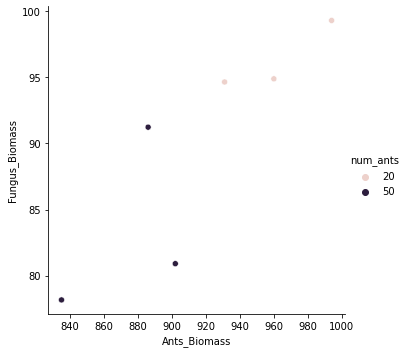

In [25]:
#data_collection = batch.get_collector_model()
sns.relplot(data=data, x='Ants_Biomass', y='Fungus_Biomass', hue='num_ants')

In [28]:
data_collection = batch.get_collector_model()
print(data_collection.keys())

# every key - value pair (nr_ants, repetition_number) contains a single model run
print(data_collection[(20,1)])

odict_keys([(50, 1), (50, 2), (20, 0), (20, 2), (50, 0), (20, 1)])
      Fungus Biomass  Ant Biomass  Ants with Leaves
0          50.000000           20                 0
1          50.000000           20                 0
2          94.100000           25                 0
3          83.218000           34                 4
4          73.713640           42                 9
...              ...          ...               ...
996       110.960812          997               174
997        99.741595         1002               178
998       101.926764          997               174
999        98.888228          996               171
1000       99.090464          997               176

[1001 rows x 3 columns]


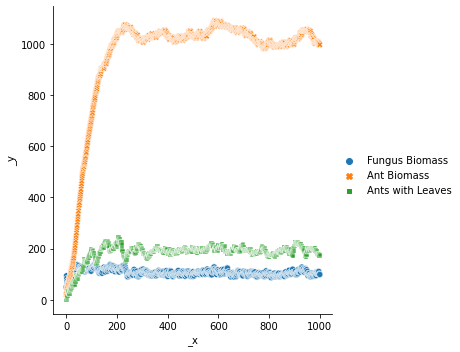

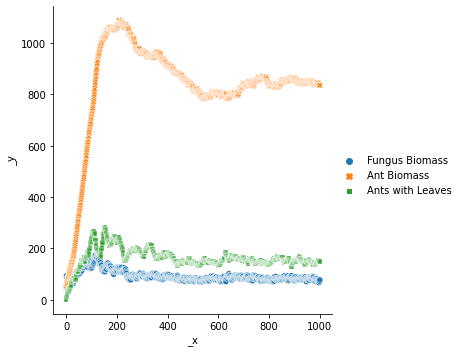

In [29]:
sns.relplot(data=data_collection[(20,1)])
sns.relplot(data=data_collection[(50,1)])